# **Rice Plant Disease Classification using CNN Transfer Learning**
___

In [1]:
trainpath= 'D:/Final/Splitted Datasets/train'
validpath='D:/Final/Splitted Datasets/val'
testpath='D:/Final/Splitted Datasets/test'

In [2]:
img_width, img_height = (224,224)

In [3]:
batch_size = 20

## Data Augumentation 
- To balance the dataset and to increase the size of training and testing dataset
- Regularization technique to minimize overfitting
- Rescaling the image is Normalizing the image

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input


In [5]:
train_data_generator= ImageDataGenerator(
        #rotation_range=350,
        preprocessing_function=preprocess_input 
    )

train_set = train_data_generator.flow_from_directory(
        trainpath,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

valid_data_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

valid_set = valid_data_generator.flow_from_directory(
        validpath,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False 
    )

test_data_generator= ImageDataGenerator()

test_set = test_data_generator.flow_from_directory(
        testpath,
        target_size=(img_width,img_height),
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=False
    )

Found 8734 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 1091 images belonging to 11 classes.


In [6]:
# To print number of batches per epoch
print('Number of Batches per epoch train=%d, valid=%d ,test=%d' % (len(train_set), len(valid_set),len(test_set)))

Number of Batches per epoch train=437, valid=55 ,test=55


## Transfer Learning

In [7]:
from tensorflow.keras.applications.mobilenet import MobileNet

In [8]:
base_model = MobileNet(
        input_shape = (img_width, img_height, 3), 
        include_top = False, 
        weights = 'imagenet'
    )

In [9]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

## Layers

In [10]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras

In [11]:
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)

x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)

x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(train_set.num_classes, activation='softmax')(x)

for layer in base_model.layers[:-100]:
   layer.trainable = False

model = tf.keras.models.Model(base_model.input, x)

model.compile(
        optimizer = Adam(learning_rate=0.000001), 
        loss = 'categorical_crossentropy', 
        metrics = ['acc']
    )

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

## Train the Model

In [13]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [14]:
saved_model = "D:/Final/Model/Rice_MobileNet_50epochs.h5"

In [15]:
# Saving the model according to the conditions  
checkpoint = ModelCheckpoint(
        saved_model, 
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        mode='auto'
    )

reduce = ReduceLROnPlateau(
        monitor='val_loss', 
        verbose=1, 
        factor=0.1, 
        patience=2, 
        mode='auto'
    )


In [16]:
epochs = 50

In [17]:
# Train the model
trained_model = model.fit(
        train_set,
        steps_per_epoch = train_set.samples//train_set.batch_size,
        epochs = epochs,
        validation_data = valid_set,
        validation_steps = valid_set.samples//valid_set.batch_size,
        callbacks=[checkpoint,reduce]
    )


Epoch 1/50
 64/436 [===>..........................] - ETA: 11:41 - loss: 5.9684 - acc: 0.0859

c:\Users\IT Room202\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


436/436 [==============================] - ETA: 0s - loss: 4.6243 - acc: 0.1366
Epoch 1: val_loss improved from inf to 1.75672, saving model to D:/Final/Model\Rice_MobileNet_50epochs.h5
436/436 [==============================] - 865s 2s/step - loss: 4.6243 - acc: 0.1366 - val_loss: 1.7567 - val_acc: 0.4306 - lr: 1.0000e-06
Epoch 2/50
436/436 [==============================] - ETA: 0s - loss: 3.1236 - acc: 0.2324
Epoch 2: val_loss improved from 1.75672 to 1.32536, saving model to D:/Final/Model\Rice_MobileNet_50epochs.h5
436/436 [==============================] - 822s 2s/step - loss: 3.1236 - acc: 0.2324 - val_loss: 1.3254 - val_acc: 0.5963 - lr: 1.0000e-06
Epoch 3/50
436/436 [==============================] - ETA: 0s - loss: 2.4993 - acc: 0.3061
Epoch 3: val_loss improved from 1.32536 to 1.11215, saving model to D:/Final/Model\Rice_MobileNet_50epochs.h5
436/436 [==============================] - 825s 2s/step - loss: 2.4993 - acc: 0.3061 - val_loss: 1.1122 - val_acc: 0.6685 - lr: 1.0000

In [18]:
model.save("mobilenet50")

s = model.to_json()
with open('mobilenet_model.json', 'w') as f:
    f.write(s)

model.save_weights("mobilenet50weights")

INFO:tensorflow:Assets written to: mobilenet50\assets


INFO:tensorflow:Assets written to: mobilenet50\assets


In [172]:
model.save("mobilenet50.h5")

In [79]:
training_accuracy      = trained_model.history['acc'][-1]
training_loss          = trained_model.history['loss'][-1]
validation_accuracy    = trained_model.history['val_acc'][-1]
validation_loss       = trained_model.history['val_loss'][-1]
print("Training Accuracy   :", training_accuracy )
print("Training Loss       :", training_loss)
print("Validation Accuracy :", validation_accuracy)
print("Validation Loss     :", validation_loss)

Training Accuracy   : 0.895914614200592
Training Loss       : 0.3048844635486603
Validation Accuracy : 0.9277777671813965
Validation Loss     : 0.19882351160049438


## Loss and Accuracy Visualization

In [19]:
import matplotlib.pyplot as plt

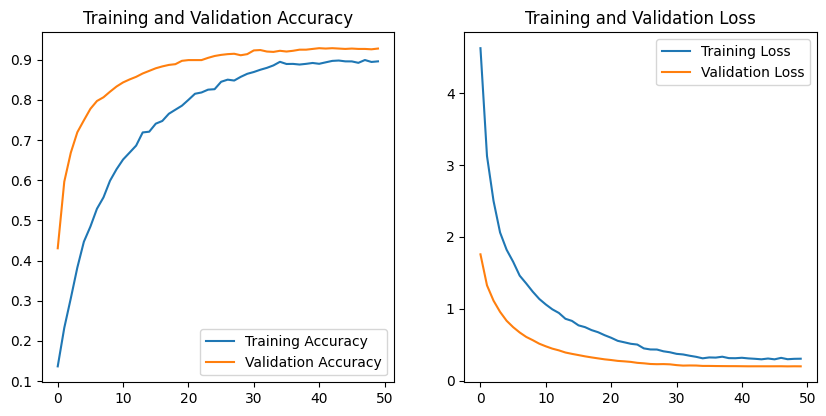

In [22]:
acc = trained_model.history['acc']
val_acc = trained_model.history['val_acc']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Load Model

In [23]:
import tensorflow as tf
new_model = tf.keras.models.load_model(saved_model)


**Testing**

In [24]:
predict = new_model.predict(
        test_set,
        steps=len(test_set),
        verbose=1
    )

55/55 [==============================] - 37s 676ms/step


In [25]:
predict

array([[7.52415359e-02, 3.35745782e-01, 9.72239897e-02, ...,
        9.99628217e-04, 8.78204685e-03, 1.45281255e-02],
       [1.39708165e-03, 3.42932999e-01, 4.44472939e-01, ...,
        1.75233476e-03, 1.63629127e-03, 6.08451606e-04],
       [2.70708906e-03, 7.46264279e-01, 3.38913538e-02, ...,
        1.42627233e-03, 1.64939358e-03, 1.56527862e-03],
       ...,
       [1.82675407e-03, 1.49648443e-01, 2.34324113e-02, ...,
        3.84894258e-04, 3.67930382e-02, 1.57926558e-03],
       [4.04345477e-03, 3.30961764e-01, 1.77732065e-01, ...,
        6.56452216e-03, 8.75281077e-03, 2.14010570e-02],
       [5.88274444e-04, 3.73630047e-01, 2.02041641e-01, ...,
        1.54428126e-03, 1.63084571e-03, 1.10097474e-03]], dtype=float32)

In [26]:
import numpy as np

In [27]:
rounded_predictions = np.argmax(predict,axis=-1)

In [52]:
rounded_predictions

array([6, 2, 1, ..., 6, 1, 1], dtype=int64)

In [53]:
rounded_predictions.shape

(1091,)

In [68]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [69]:
test_set.class_indices

{'Bacterial_Blight': 0,
 'Blast': 1,
 'Brown_Spot': 2,
 'False_Smut': 3,
 'Healthy': 4,
 'Healthy_Flowers': 5,
 'Hispa': 6,
 'Leaf_Smut': 7,
 'Sheath_Blight': 8,
 'Tungro': 9,
 'Unhealthy_Flowers': 10}

In [70]:
test_labels=test_set.classes
test_labels

array([ 0,  0,  0, ..., 10, 10, 10])

In [71]:
test_labels.shape

(1091,)

In [175]:
class_list = []
for keys in test_set.class_indices.keys():
    class_list.append(keys)

In [ ]:
# import sklearn
# precision = sklearn.metrics.precision_score(test_labels, rounded_predictions, pos_label="positive")
# print(precision)

**Confusiion Matrix**

In [178]:
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)
cm

array([[ 0, 57, 18,  1,  1,  0, 20,  3,  0,  0,  0],
       [ 0, 55, 11,  0,  3,  0, 27,  4,  0,  0,  0],
       [ 0, 52, 23,  0,  1,  0, 22,  2,  0,  0,  0],
       [ 0, 42, 11,  0, 21,  0, 22,  4,  0,  0,  0],
       [ 0, 25, 11,  0, 13,  0, 37,  8,  0,  0,  0],
       [ 0, 52,  4,  1, 21,  0, 18,  4,  0,  0,  0],
       [ 0, 11, 11,  0,  0,  0, 75,  0,  0,  0,  0],
       [ 0, 16,  7,  0,  1,  0, 26, 50,  0,  0,  0],
       [ 0, 40,  3,  1, 12,  0, 33, 11,  0,  0,  0],
       [ 0, 46, 12,  0,  7,  0, 30,  5,  0,  0,  0],
       [ 0, 46, 11,  0, 13,  0, 23,  7,  0,  0,  0]], dtype=int64)

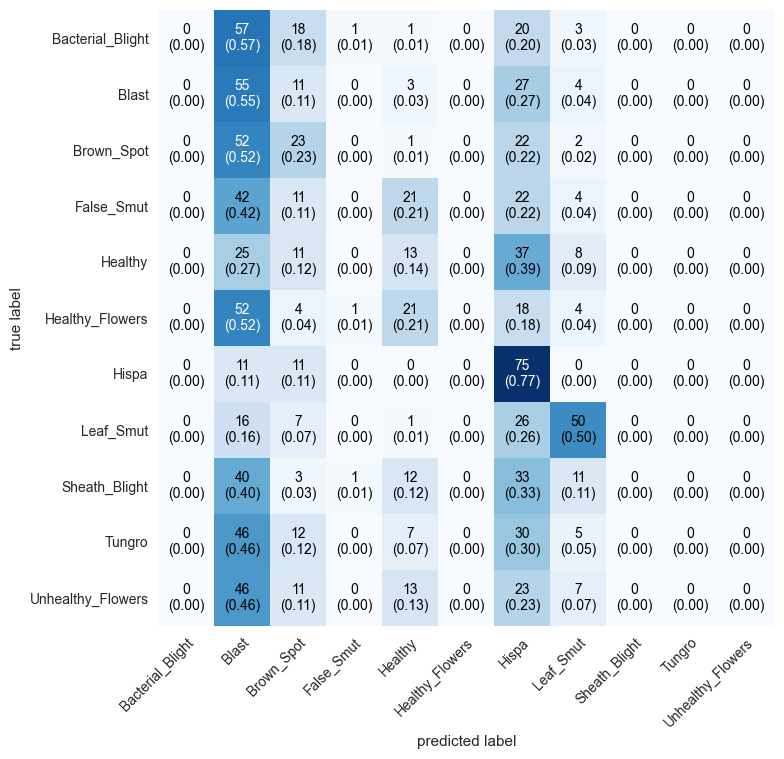

In [182]:
fig,ax=plot_confusion_matrix(conf_mat=cm,figsize=(8,8),show_normed=True, class_names=class_list)
plt.show()


In [74]:
print('test accuracy: {0:2f}'.format((np.diagonal(cm).sum()/cm.sum().sum()*100)))

test accuracy: 19.798350


<AxesSubplot: >

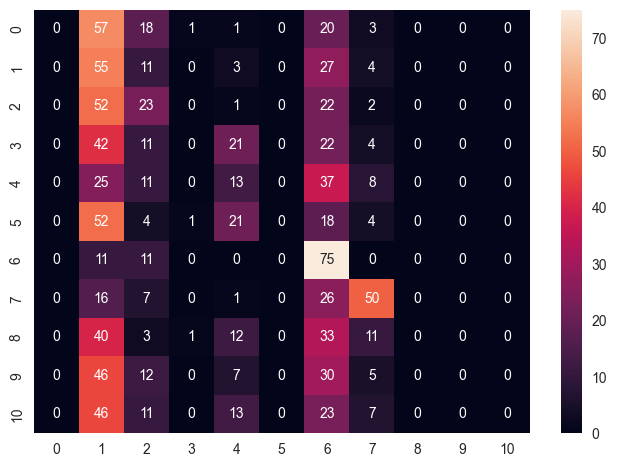

In [183]:
import seaborn as sns
sns.heatmap(cm, annot=True)

<AxesSubplot: >

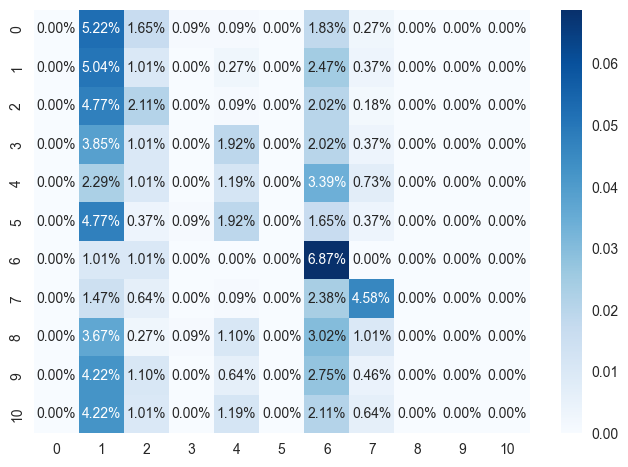

In [185]:
sns.heatmap(
        cm/np.sum(cm), 
        annot=True, 
        fmt='.2%', 
        cmap='Blues'
    )

Classification Report

In [75]:
import sklearn.metrics as metrics

In [76]:
class_list = []
for keys in test_set.class_indices.keys():
    class_list.append(keys)

class_list

['Bacterial_Blight',
 'Blast',
 'Brown_Spot',
 'False_Smut',
 'Healthy',
 'Healthy_Flowers',
 'Hispa',
 'Leaf_Smut',
 'Sheath_Blight',
 'Tungro',
 'Unhealthy_Flowers']

In [77]:

classify_report = metrics.classification_report(
        y_true=test_labels, 
        y_pred=rounded_predictions,
        target_names=class_list
    )

print('classify_report : \n', classify_report)


classify_report : 
                    precision    recall  f1-score   support

 Bacterial_Blight       0.00      0.00      0.00       100
            Blast       0.12      0.55      0.20       100
       Brown_Spot       0.19      0.23      0.21       100
       False_Smut       0.00      0.00      0.00       100
          Healthy       0.14      0.14      0.14        94
  Healthy_Flowers       0.00      0.00      0.00       100
            Hispa       0.23      0.77      0.35        97
        Leaf_Smut       0.51      0.50      0.51       100
    Sheath_Blight       0.00      0.00      0.00       100
           Tungro       0.00      0.00      0.00       100
Unhealthy_Flowers       0.00      0.00      0.00       100

         accuracy                           0.20      1091
        macro avg       0.11      0.20      0.13      1091
     weighted avg       0.11      0.20      0.13      1091



c:\Users\IT Room202\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\IT Room202\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\IT Room202\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [78]:
overall_accuracy = metrics.accuracy_score(
        y_true=test_labels, 
        y_pred=rounded_predictions
    )
acc_for_each_class = metrics.precision_score(
        y_true=test_labels, 
        y_pred=rounded_predictions, 
        average=None
    )
average_accuracy = np.mean(acc_for_each_class)
score = metrics.accuracy_score(
        y_true=test_labels, 
        y_pred=rounded_predictions
    )

print('ac_for_each_class : \n', acc_for_each_class)
print('average_accuracy: {0:2f}'.format(average_accuracy))
print('overall_accuracy: {0:2f}'.format(overall_accuracy))
print('score: {0:f}'.format(score))

ac_for_each_class : 
 [0.         0.12443439 0.18852459 0.         0.13978495 0.
 0.22522523 0.51020408 0.         0.         0.        ]
average_accuracy: 0.108016
overall_accuracy: 0.197984
score: 0.197984


c:\Users\IT Room202\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC Curve

In [116]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_labels, predict[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_labels))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

C:\Users\IT Room202\AppData\Local\Temp\ipykernel_2244\1144541135.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


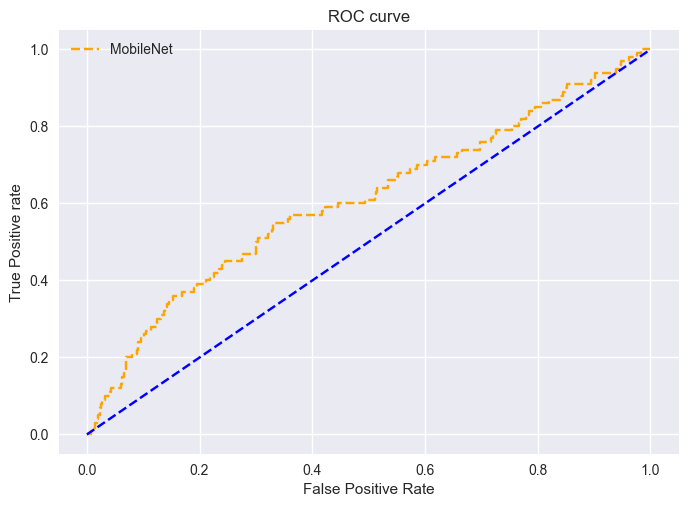

In [117]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='MobileNet')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

ROC Area Under Curve (AUC) Score

In [134]:
from sklearn.metrics import roc_auc_score

# auc scores
# auc_score1 = roc_auc_score(test_labels, predict[:,1])
auc_score1 = roc_auc_score(y_score=predict, y_true=test_labels, multi_class="ovr",average=None)

ind = 0
for score in auc_score1:
    print("%s : %.3f" % (class_list[ind], score))
    ind += 1

Bacterial_Blight : 0.626
Blast : 0.607
Brown_Spot : 0.668
False_Smut : 0.733
Healthy : 0.645
Healthy_Flowers : 0.576
Hispa : 0.830
Leaf_Smut : 0.826
Sheath_Blight : 0.649
Tungro : 0.586
Unhealthy_Flowers : 0.540


___

(1, 224, 224, 3)


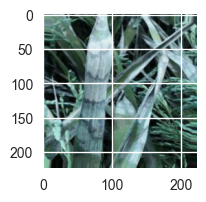

In [203]:
import cv2
import numpy as np
image=cv2.imread("D:/Testing/sheathblight (2).jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_resized=cv2.resize(image, (img_width, img_height))
image=np.expand_dims(img_resized,axis=0)
print(image.shape)

plt.figure(figsize = (2,2))
plt.imshow(img_resized)
plt.show()

In [204]:
prediction = new_model.predict(image)
print(prediction)

1/1 [==============================] - 1s 673ms/step
[[0.00099181 0.03991186 0.02484532 0.00648584 0.05955888 0.00424421
  0.44817913 0.40713045 0.00582096 0.00187118 0.00096041]]


In [205]:
class_output = class_list[np.argmax(prediction)]
print(class_output)

Hispa


In [206]:
predicted_acuracy = ("{:.2%}".format(np.array(prediction[0])[np.argmax(prediction)]))
print(predicted_acuracy)

44.82%


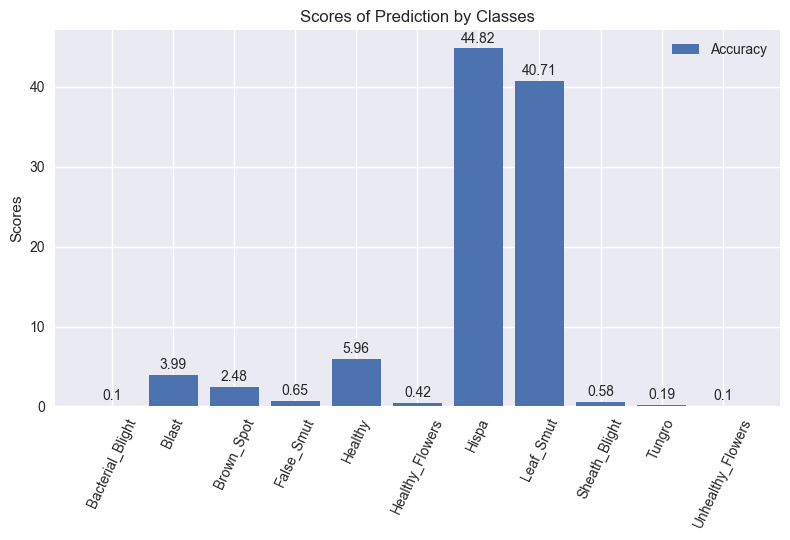

In [208]:
import matplotlib.pyplot as plt
import numpy as np

labels = class_list
values = list(np.array(np.around(prediction[0] * 100,2)))

x = np.arange(len(labels))  # the label locations
width = 0.80  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, values, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores of Prediction by Classes')
ax.set_xticks(x, labels)
plt.xticks(rotation=65)
ax.legend()

ax.bar_label(rects1, padding=2)

fig.tight_layout()

plt.show()

___

1/1 [==============================] - 0s 189ms/step


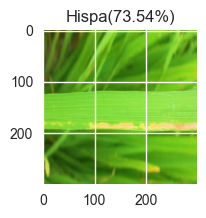

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 142ms/step


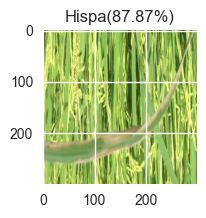

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 459ms/step


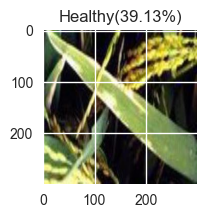

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 393ms/step


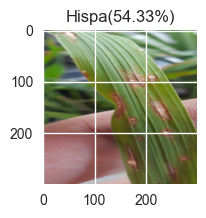

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 159ms/step


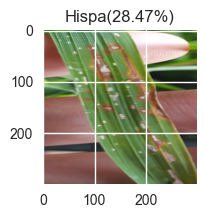

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 190ms/step


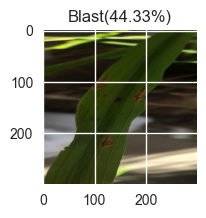

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 186ms/step


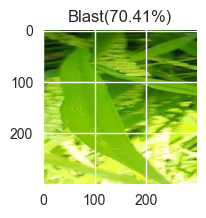

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 166ms/step


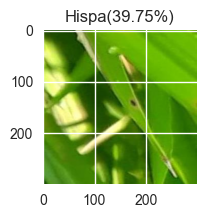

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 274ms/step


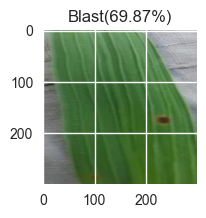

----------------------------------------------------------------------------------
1/1 [==============================] - 1s 642ms/step


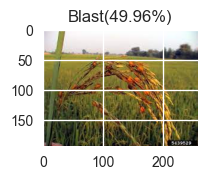

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 218ms/step


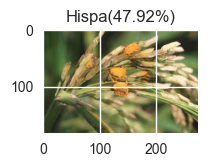

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 154ms/step


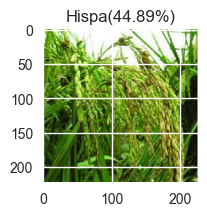

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 160ms/step


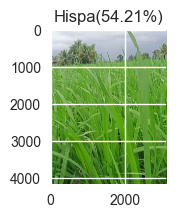

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 222ms/step


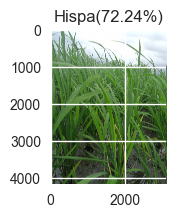

----------------------------------------------------------------------------------
1/1 [==============================] - 1s 505ms/step


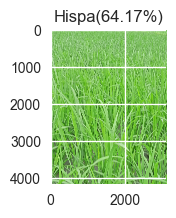

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 176ms/step


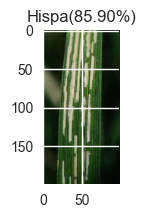

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 212ms/step


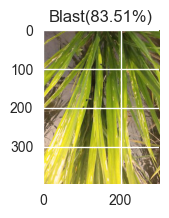

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 447ms/step


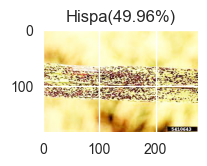

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 244ms/step


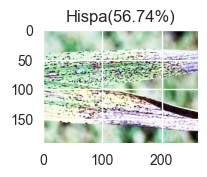

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 187ms/step


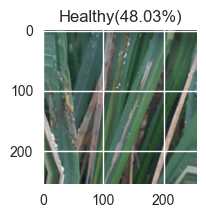

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 196ms/step


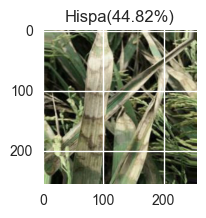

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 154ms/step


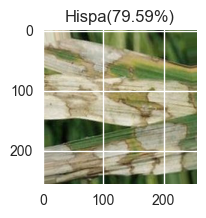

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 178ms/step


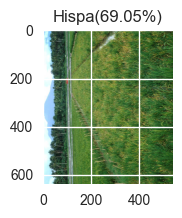

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 323ms/step


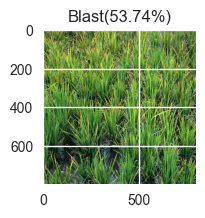

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 479ms/step


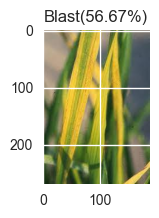

----------------------------------------------------------------------------------


In [209]:
import os
import cv2
import numpy as np
path = "D:/Testing"
for img in os.listdir(path):
    try:
        image = cv2.imread(os.path.join(path, img))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_resized=cv2.resize(image, (img_width, img_height))
        new_image=np.expand_dims(img_resized,axis=0)
        # print(image.shape)

        prediction = new_model.predict(new_image)

        class_output = class_list[np.argmax(prediction)]
        #print(class_output)
        predicted_acuracy = ("{:.2%}".format(np.array(prediction[0])[np.argmax(prediction)]))
        #print(predicted_acuracy)
        
        plt.figure(figsize = (2,2))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(class_output + "(" + predicted_acuracy + ")")
        plt.show()

    except Exception as e:
        print(e)
    print("----------------------------------------------------------------------------------")

---

1/1 [==============================] - 0s 446ms/step
34.10%
Invalid Image!  try to test another image.


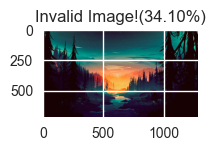

In [210]:
import cv2
import numpy as np

img=cv2.imread("D:/invalid.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized=cv2.resize(img, (img_width, img_height))
image=np.expand_dims(img_resized,axis=0)
#print(image.shape)

# prediction = trained_model.model.predict(image)
prediction = new_model.predict(image)
#print(prediction)

class_output = class_list[np.argmax(prediction)]
#print(class_output)

accuracy = np.array(prediction[0])[np.argmax(prediction)]
predicted_acuracy = ("{:.2%}".format(accuracy))
print(predicted_acuracy)

if(accuracy * 100 < 75):
    class_output = "Invalid Image!"
    print(class_output, " try to test another image.")

plt.figure(figsize = (2,2))
plt.imshow(img)
plt.title(class_output + "(" + predicted_acuracy + ")")
plt.show()

___